In [71]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
%matplotlib inline

In [2]:
yahoo_db = 'yahoo.db'
tmx_db = 'tmx.db'
advfn_db = 'advfn.db'

yahoo_database = sqlite3.connect(yahoo_db)
tmx_database = sqlite3.connect(tmx_db)
advfn_database = sqlite3.connect(advfn_db)


In [82]:
tmx_sql = '''SELECT date, eps FROM tmx_earnings WHERE symbol = "BNS"'''
df_tmx = pd.read_sql_query(tmx_sql, tmx_database)
df_tmx.columns = ['date', 'eps']
df_tmx['date_parsed'] = df_tmx['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_tmx.drop(columns = 'date', inplace = True)

aav_sql = '''SELECT Date, Close FROM aav_prices WHERE symbol = "BNS"'''
df_aav = pd.read_sql_query(aav_sql, yahoo_database)
df_aav.columns = ['date', 'close']
df_aav['date_parsed'] = df_aav['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_aav.drop(columns = 'date', inplace = True)

yahoo_prices_sql = '''SELECT Date, Close FROM tsx_prices WHERE symbol = "BNS"'''
df_y_price = pd.read_sql_query(yahoo_prices_sql, yahoo_database)
df_y_price.columns = ['date', 'close']
df_y_price['date_parsed'] = df_y_price['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_y_price.drop(columns = 'date', inplace = True)

divs_sql = '''SELECT Date, Dividends, split_factor FROM divs WHERE symbol = "BNS"'''
df_divs = pd.read_sql_query(divs_sql, yahoo_database) 
df_divs.columns = ['date', 'div', 'split_factor']
df_divs['date_parsed'] = df_divs['date'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
df_divs.drop(columns = 'date', inplace = True)



In [83]:
df_price = pd.concat([df_y_price, df_aav])
print('Before: ' + str(df_price.shape[0]))
df_price.drop_duplicates(subset='date_parsed', inplace = True)
print('After: ' + str(df_price.shape[0]))
df_price

Before: 6309
After: 6210


,close,date_parsed
0,6.1575,1995-01-12
1,6.25,1995-01-13
2,6.375,1995-01-16
3,6.2825,1995-01-17
4,6.345,1995-01-18
5,6.3125,1995-01-19
6,6.1875,1995-01-20
7,6.1575,1995-01-23
8,6.2825,1995-01-24
9,6.345,1995-01-25


In [90]:
df = df_price.join(df_tmx.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [91]:
df = df.join(df_divs.set_index('date_parsed'), on = 'date_parsed', how = 'outer', sort = True)

In [92]:
df.fillna(method='ffill', inplace = True)

df.set_index(df['date_parsed'], inplace= True)
df.head(5)

,close,date_parsed,eps,div,split_factor
date_parsed,,,,,
1994-11-30,NaN,1994-11-30,0.2025,NaN,NaN
1995-01-12,6.1575,1995-01-12,0.2025,NaN,NaN
1995-01-13,6.25,1995-01-13,0.2025,NaN,NaN
1995-01-16,6.375,1995-01-16,0.2025,NaN,NaN
1995-01-17,6.2825,1995-01-17,0.2025,NaN,NaN


In [93]:
#this is for current quarter only - go back and fill the TTM on df_earnings and df_divs
df['pe'] = 0.0
df['dy'] = 0.0

In [100]:
def process_row(row):
    if (row['close'] != row['close']) | (row['close'] == 'null'):
        df.at[row['date_parsed'], 'pe'] = np.NaN
        df.at[row['date_parsed'], 'dy'] = np.NaN
        return
    if row['eps'] == row['eps']:
        if row['eps'] == 0:
            df.at[row['date_parsed'], 'pe'] = np.NaN
        else:
            df.at[row['date_parsed'], 'pe'] = float(row['close']) / (4*row['eps'])
    
    if row['eps'] == row['eps']:
        if row['close'] == 0:
            df.at[row['date_parsed'], 'dy'] = np.NaN
        else:
            df.at[row['date_parsed'], 'dy'] = 4* row['div'] / (float(row['close']) * row['split_factor'])
        
    
    

In [101]:
df.apply(process_row, axis = 1)
df

,close,date_parsed,eps,div,split_factor,pe,dy
date_parsed,,,,,,,
1994-11-30,NaN,1994-11-30,0.2025,NaN,NaN,NaN,NaN
1995-01-12,6.1575,1995-01-12,0.2025,NaN,NaN,7.601852,NaN
1995-01-13,6.25,1995-01-13,0.2025,NaN,NaN,7.716049,NaN
1995-01-16,6.375,1995-01-16,0.2025,NaN,NaN,7.870370,NaN
1995-01-17,6.2825,1995-01-17,0.2025,NaN,NaN,7.756173,NaN
1995-01-18,6.345,1995-01-18,0.2025,NaN,NaN,7.833333,NaN
1995-01-19,6.3125,1995-01-19,0.2025,NaN,NaN,7.793210,NaN
1995-01-20,6.1875,1995-01-20,0.2025,NaN,NaN,7.638889,NaN
1995-01-23,6.1575,1995-01-23,0.2025,NaN,NaN,7.601852,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002013B2AB4A8>]],
      dtype=object)

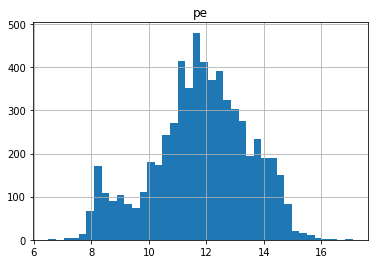

In [102]:
df.hist(['pe'], bins=40)


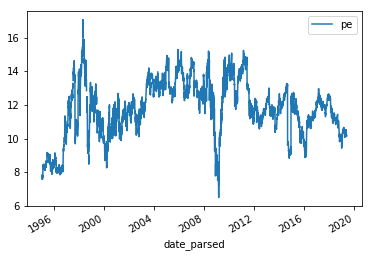

In [103]:
df.plot(x = 'date_parsed', y ='pe')

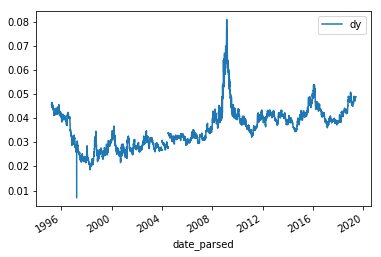

In [104]:
df.plot(x = 'date_parsed', y ='dy')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002013B4A72E8>]],
      dtype=object)

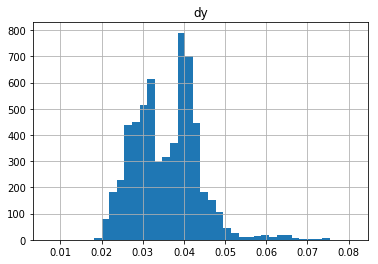

In [105]:
df.hist(['dy'], bins=40)

In [108]:
df['dy'].mean()

0.03584753429194877

In [109]:
df['pe'].mean()

11.798968627647056